# ML BATTLE ROYAL - PREDICT HEALTH OUTCOMES OF HORSES

Parts of our notebook: 
* Data Load 
* Exploratory Data Analysis
* Data Visualization
* Preprocessing
* Modelling
* Submission

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Data Load

In [2]:
train = pd.read_csv(r"./../../data/raw/train.csv")
test = pd.read_csv(r"./../../data/raw/test.csv")

# Exploratory Data Analysis

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1235 non-null   int64  
 1   surgery                           1235 non-null   int64  
 2   age                               1235 non-null   int64  
 3   hospital_number                   1235 non-null   int64  
 4   rectal_temp                       1235 non-null   float64
 5   pulse                             1235 non-null   float64
 6   respiratory_rate                  1235 non-null   float64
 7   nasogastric_reflux_ph             1235 non-null   float64
 8   packed_cell_volume                1235 non-null   float64
 9   total_protein                     1235 non-null   float64
 10  abdomo_protein                    1235 non-null   float64
 11  surgical_lesion                   1235 non-null   int64  
 12  lesion

In [3]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [5]:
train.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [9]:
train.isnull().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

# Data Visualization

C:\Users\Satriock\AppData\Local\Temp\ipykernel_16372\4201091745.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data_test[col], ax=axes[i, 0], label='Test', color=color_test)


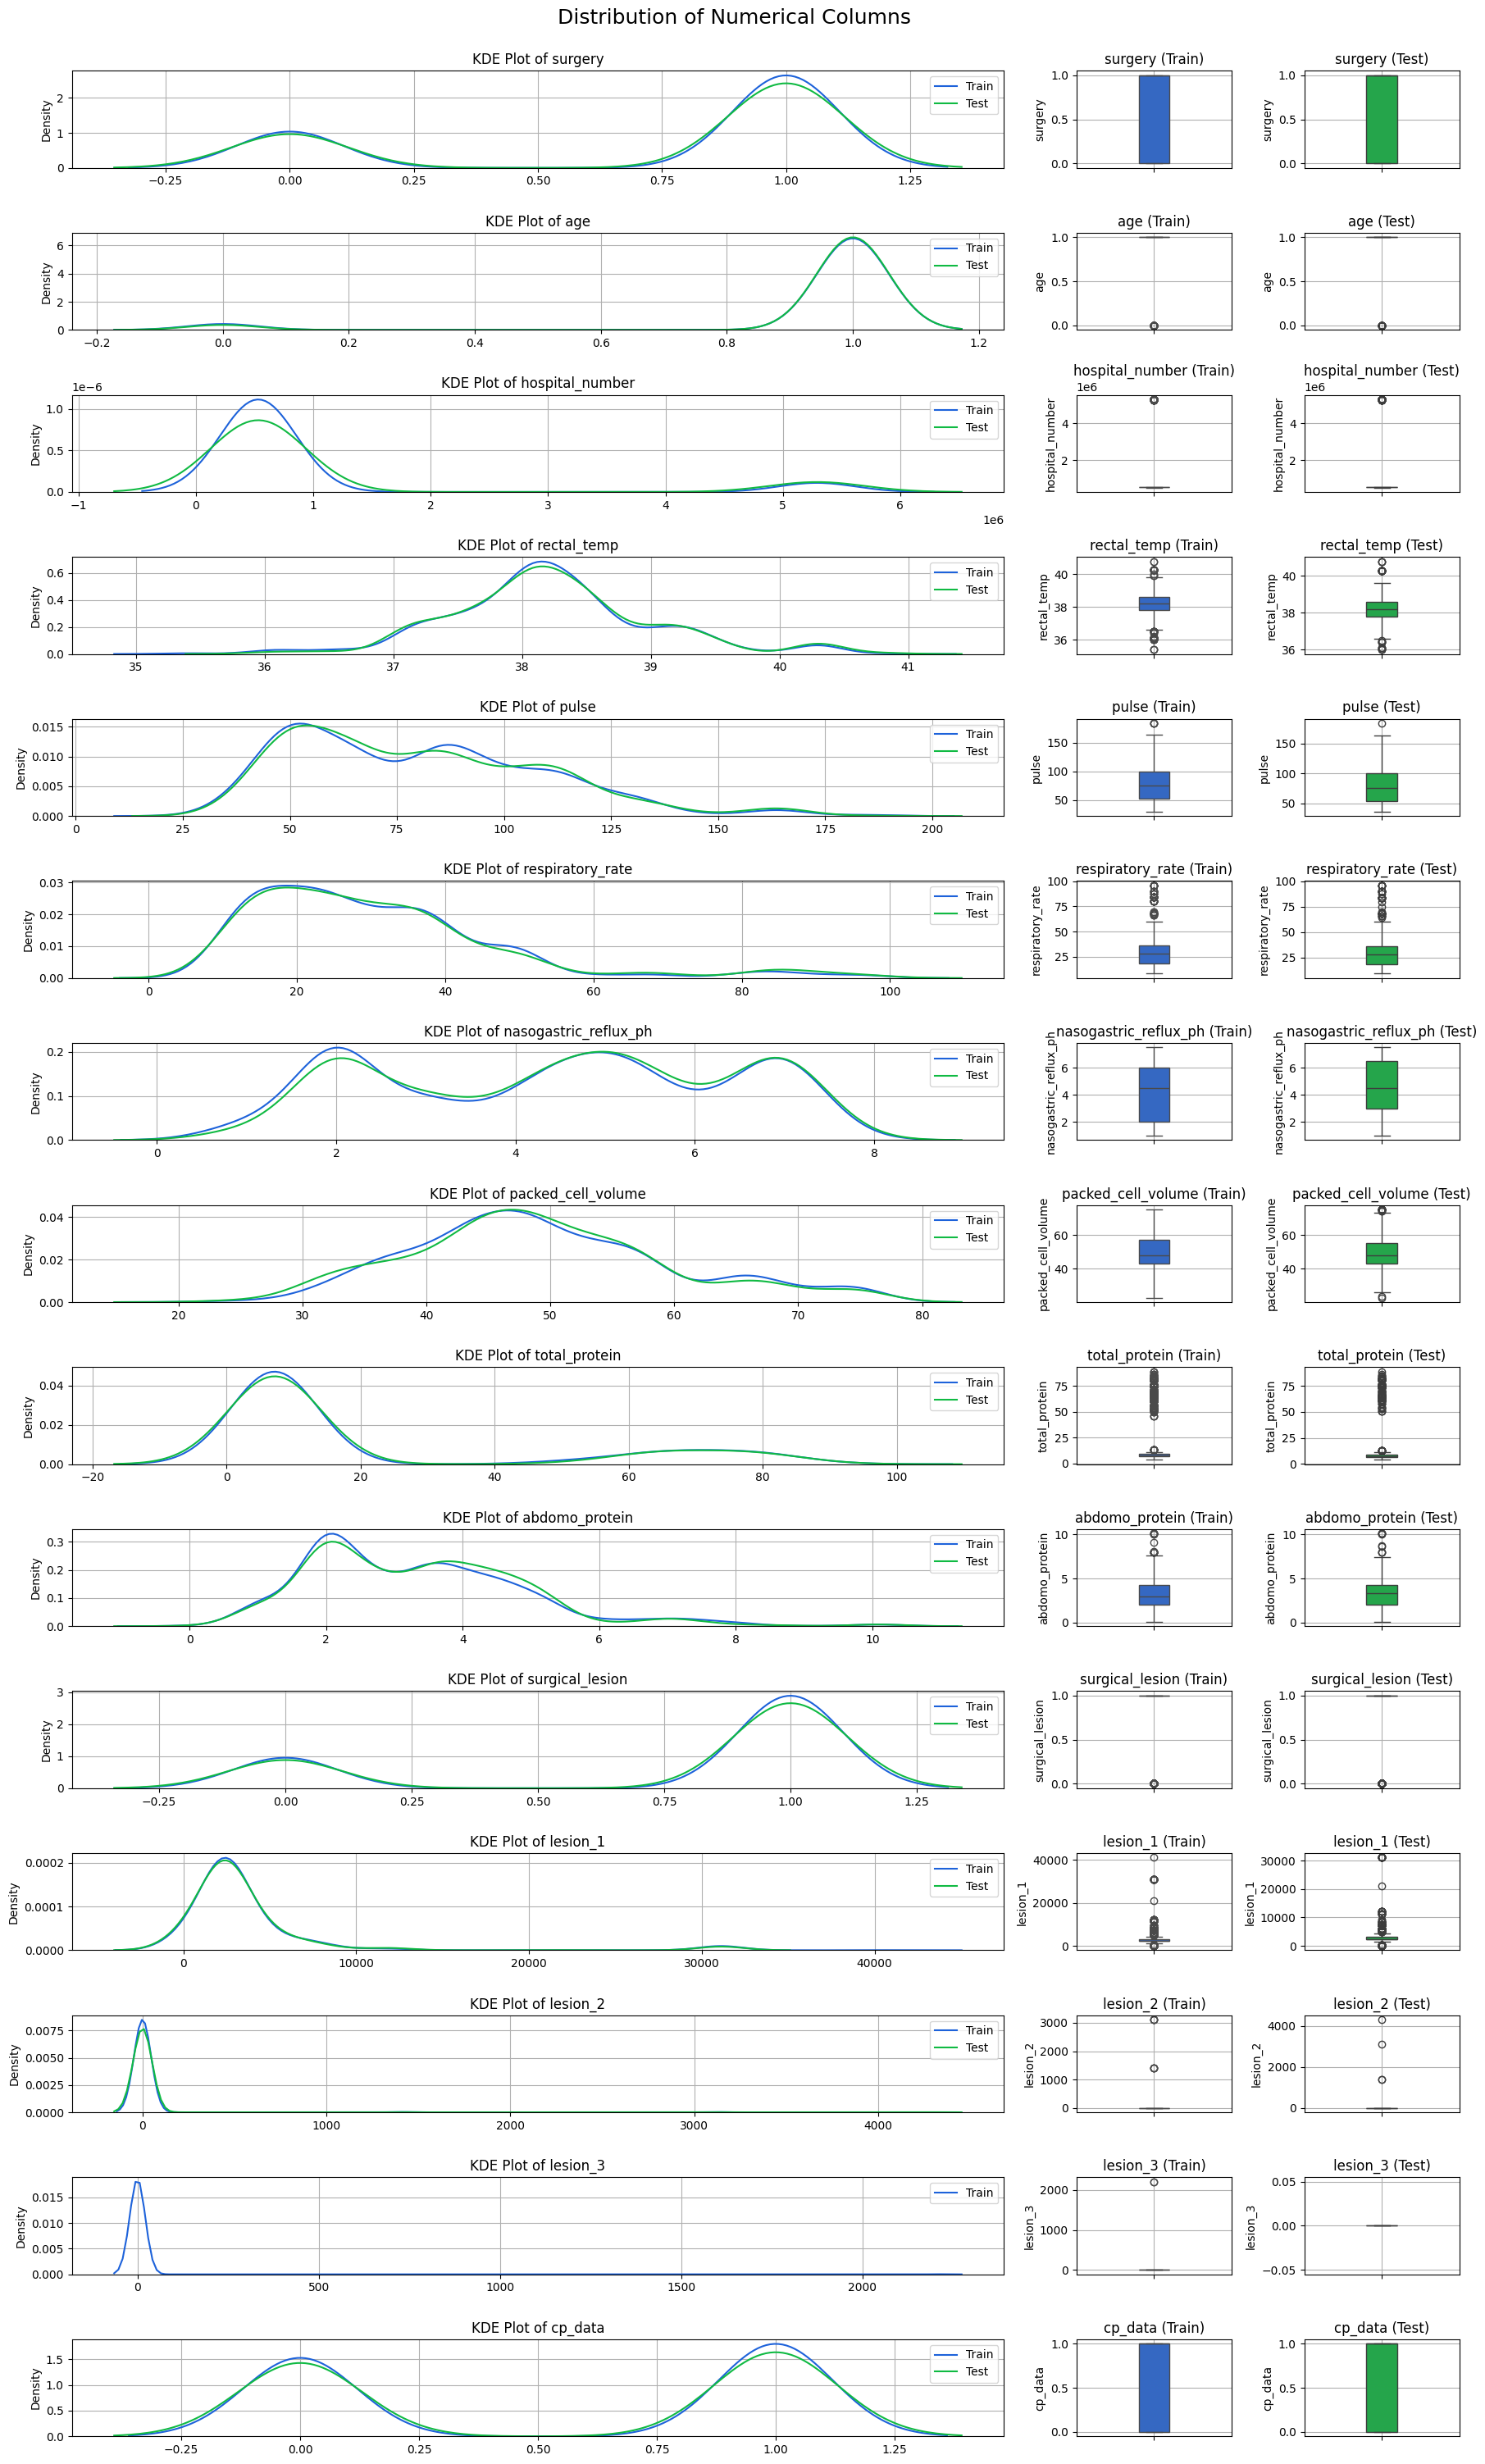

In [42]:
data_train = train.drop(columns=['outcome', 'id'])
data_test = test.drop(columns=['id'])
num_cols = data_train.select_dtypes(include='number').columns

color_train = '#1D62DA'
color_test = '#10BA43'

fig, axes = plt.subplots(len(num_cols), 3, figsize=(18, 30), gridspec_kw={'width_ratios': [0.90, 0.15, 0.15]})

for i, col in enumerate(num_cols):
    # KDE plot
    sns.kdeplot(data=data_train[col], ax=axes[i, 0], label='Train', color=color_train)
    sns.kdeplot(data=data_test[col], ax=axes[i, 0], label='Test', color=color_test)
    axes[i, 0].grid(True)
    axes[i, 0].set_title('KDE Plot of ' + col)
    axes[i, 0].set_xlabel('')
    axes[i, 0].legend()

    # Boxplot untuk data train
    sns.boxplot(y=col, data=data_train, ax=axes[i, 1], color=color_train, width=0.2)
    axes[i, 1].grid(True)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(col + ' (Train)')

    # Boxplot untuk data test
    sns.boxplot(y=col, data=data_test, ax=axes[i, 2], color=color_test, width=0.2)
    axes[i, 2].grid(True)
    axes[i, 2].set_xlabel('')
    axes[i, 2].set_title(col + ' (Test)')

plt.suptitle('Distribution of Numerical Columns', fontsize=18, y=1)
plt.tight_layout()
plt.show()

C:\Users\Satriock\AppData\Local\Temp\ipykernel_16372\3577316964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outcome', data=train, palette='viridis')


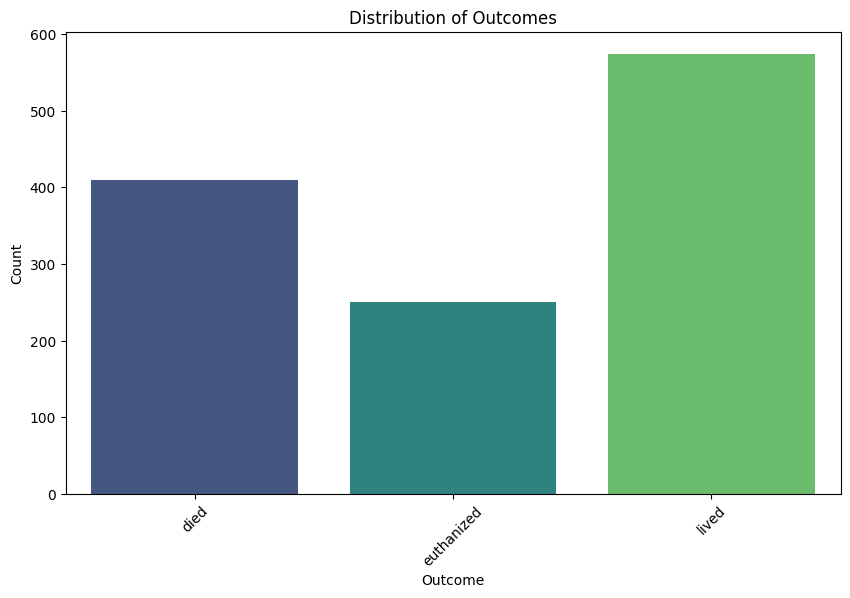

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='outcome', data=train, palette='viridis')
plt.title('Distribution of Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Preprocessing

In [12]:
train_missing_cols = train.columns[train.isnull().any()] 
test_missing_cols = test.columns[test.isnull().any()]

train_missing_cols = list(train_missing_cols) 
test_missing_cols = list(test_missing_cols)

In [13]:
def replace_missing_with_most_common(data, columns):
    for column in columns:
        col_most_common = data[column].value_counts().index[0]
        data[column] = data[column].replace({np.nan: col_most_common})
    return data

train = replace_missing_with_most_common(train, train_missing_cols)
test = replace_missing_with_most_common(test,test_missing_cols)

In [14]:
numeric_train = train.select_dtypes(include = [np.number]) 
numeric_test = test.select_dtypes(include = [np.number])

categorical_train = train.select_dtypes(exclude = [np.number])
categorical_test = test.select_dtypes(exclude = [np.number])

One hot encoding: replaces categorical values ​​with numeric values ​​for some columns in a dataset

In [15]:
train['surgery'] = train['surgery'].replace({'yes': 1,'no': 0})
train['age'] = train['age'].replace({'adult': 1,'young': 0})
train['surgical_lesion'] = train['surgical_lesion'].replace({'yes': 1,'no': 0})
train['cp_data'] = train['cp_data'].replace({'yes': 1,'no': 0})
train['outcome'] = train['outcome'].replace({'died': 0,'euthanized': 1,'lived': 2})

columns = ['temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time','pain','peristalsis','abdominal_distention',
'nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance']
train = pd.get_dummies(data = train,columns=columns)

In [16]:
test['surgery'] = test['surgery'].replace({'yes': 1,'no': 0})
test['age'] = test['age'].replace({'adult': 1,'young': 0})
test['surgical_lesion'] = test['surgical_lesion'].replace({'yes': 1,'no': 0})
test['cp_data'] = test['cp_data'].replace({'yes': 1,'no': 0})

test = pd.get_dummies(data = test,columns = ['temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time','pain',
'peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance'])

In [17]:
train.isnull().sum()

id                                 0
surgery                            0
age                                0
hospital_number                    0
rectal_temp                        0
                                  ..
abdomen_normal                     0
abdomen_other                      0
abdomo_appearance_clear            0
abdomo_appearance_cloudy           0
abdomo_appearance_serosanguious    0
Length: 69, dtype: int64

In [18]:
test.isnull().sum()

id                                 0
surgery                            0
age                                0
hospital_number                    0
rectal_temp                        0
                                  ..
abdomen_normal                     0
abdomen_other                      0
abdomo_appearance_clear            0
abdomo_appearance_cloudy           0
abdomo_appearance_serosanguious    0
Length: 65, dtype: int64

In [19]:
train.to_csv('./../../data/processed/cleaned_train.csv', index=False)
test.to_csv('./../../data/processed/cleaned_test.csv', index=False)

In [22]:
y_train = train['outcome']
X_train_id = train['id']
X_train = train.drop(columns = ['outcome', 'id'])

X_test_id = test['id']
X_test = test.drop(columns = 'id')


Adding a new column to the training and testing data with a default value of 0. This is done to ensure that both datasets have the same columns

In [23]:
X_train['pain_moderate'] = 0 
X_test['nasogastric_reflux_slight'] = 0
X_test['pain_slight'] = 0
X_test['peristalsis_distend_small'] = 0
X_test['rectal_exam_feces_serosanguious'] = 0
X_test = X_test.reindex(X_train.columns, axis=1)

In [24]:
train_weights = compute_class_weight(class_weight = 'balanced',classes = np.unique(train['outcome']),y = train['outcome'])
skf = StratifiedKFold(n_splits = 5)

Adjust the scale of the training data

In [25]:
rs=RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_test_rs = rs.transform(X_test)

# Modelling

### LightGBM

In [26]:
best_random_lgbm = LGBMClassifier(n_estimators = 150,learning_rate = 0.01,num_leaves = 8,class_weight='balanced')
best_random_lgbm.fit(X_train_rs, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 1235, number of used features: 58
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(class_weight='balanced', learning_rate=0.01, n_estimators=150,
               num_leaves=8)

### XGBoost

In [27]:
best_grid_xgb = XGBClassifier(max_depth = 11,max_leaves = 8,n_estimators = 150)
best_grid_xgb.fit(X_train_rs, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=8,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### CatBoost

In [28]:
orig_catboost = CatBoostClassifier(random_state = 42,boosting_type = 'Ordered',verbose = 0)
orig_catboost.fit(X_train_rs, y_train)

### Prediction

In [45]:
lgbm_predictions = best_random_lgbm.predict(X_test_rs)
xgb_predictions = best_grid_xgb.predict(X_test_rs)
catboost_predictions = orig_catboost.predict(X_test_rs)

In [46]:
from sklearn.model_selection import cross_val_score

lgbm_accuracy = cross_val_score(best_random_lgbm, X_train_rs, y_train, cv=5, scoring='accuracy').mean()
xgb_accuracy = cross_val_score(best_grid_xgb, X_train_rs, y_train, cv=5, scoring='accuracy').mean()
catboost_accuracy = cross_val_score(orig_catboost, X_train_rs, y_train, cv=5, scoring='accuracy').mean()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 58
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 58
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start traini

In [48]:
print("LGBM Accuracy:", lgbm_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)
print("CatBoost Accuracy:", catboost_accuracy)

LGBM Accuracy: 0.688259109311741
XGBoost Accuracy: 0.697165991902834
CatBoost Accuracy: 0.71417004048583


# Submission

In [ ]:
value_to_replace = {0: 'died', 1: 'euthanized', 2: 'lived'}

lgbm_predictions = best_random_lgbm.predict(X_test_rs)
lgbm_predictions_worded = np.vectorize(value_to_replace.get)(lgbm_predictions)
lgbm_submission_df = pd.DataFrame({'id': X_test_id, 'outcome': lgbm_predictions_worded})
lgbm_submission_df.to_csv('lgbm_submission.csv', index=False)

In [ ]:
value_to_replace = {0: 'died', 1: 'euthanized', 2: 'lived'}

xgb_predictions = best_grid_xgb.predict(X_test_rs)
xgb_predictions_worded = np.vectorize(value_to_replace.get)(xgb_predictions)
xgb_submission_df = pd.DataFrame({'id': X_test_id, 'outcome': xgb_predictions_worded})
xgb_submission_df.to_csv('xgb_submission.csv', index=False)

In [ ]:
value_to_replace = {0: 'died', 1: 'euthanized', 2: 'lived'}

catboost_predictions_worded = np.vectorize(value_to_replace.get)(catboost_predictions)

X_test_id = np.array(X_test_id).ravel()
catboost_predictions_worded = catboost_predictions_worded.ravel()

catboost_submission_df = pd.DataFrame({'id': X_test_id, 'outcome': catboost_predictions_worded})
catboost_submission_df.to_csv('catboost_submission.csv', index=False)

### Stack

Stacking for XGB, LGBM, and CatBoost

In [ ]:
def stack_predict_submit(models, X_train, y_train, X_test, X_test_id):
    stacked_model = StackingClassifier(stack_method = 'predict_proba',estimators = models,cv = 'prefit',n_jobs = -1)
    stacked_model.fit(X_train, y_train)
    stacked_predictions = stacked_model.predict(X_test)
    value_to_replace = {0: 'died', 1: 'euthanized', 2: 'lived'}
    stacked_predictions_worded = np.vectorize(value_to_replace.get)(stacked_predictions)
    submission_combined = np.column_stack((X_test_id, stacked_predictions_worded))
    submission_df = pd.DataFrame(submission_combined, columns = ['id', 'outcome'])
    submission_csv = submission_df.to_csv('submission.csv', index=False)
    return submission_csv

best_random_models_list = [('lgbm', best_random_lgbm),('xgb', best_grid_xgb),('orig_catboost', orig_catboost)]
stack_predict_submit(best_random_models_list,X_train_rs,y_train,X_test_rs, X_test_id)

In [ ]:
def stack_predict_submit(models, X_train, y_train, X_test, X_test_id):
    stacked_model = StackingClassifier(stack_method='predict_proba', estimators=models, cv='prefit', n_jobs=-1)
    stacked_model.fit(X_train, y_train)
    stacked_predictions = stacked_model.predict(X_test)
    value_to_replace = {0: 'died', 1: 'euthanized', 2: 'lived'}
    stacked_predictions_worded = np.vectorize(value_to_replace.get)(stacked_predictions)
    submission_combined = np.column_stack((X_test_id, stacked_predictions_worded))
    submission_df = pd.DataFrame(submission_combined, columns=['id', 'outcome'])
    submission_csv = submission_df.to_csv('stack-XGB-CatBoost-submission.csv', index=False)
    return submission_csv

xgb_catboost_models_list = [('xgb', best_grid_xgb), ('catboost', orig_catboost)]
stack_predict_submit(xgb_catboost_models_list, X_train_rs, y_train, X_test_rs, X_test_id)

### Ensemble

Ensemble among XGB-CatBoost, LGBM-CatBoost, LGBM-XGB, LGBM-XGB-CatBoost

In [ ]:
X_train_ensembleXGBCat = pd.DataFrame({
    'xgb': best_grid_xgb.predict(X_train_rs).flatten(),
    'catboost': orig_catboost.predict(X_train_rs).flatten()
})

ensemble_modelXGBCat = RandomForestClassifier(random_state=42)
ensemble_modelXGBCat.fit(X_train_ensembleXGBCat, y_train)

X_test_ensembleXGBCat = pd.DataFrame({
    'xgb': best_grid_xgb.predict(X_test_rs).flatten(),
    'catboost': orig_catboost.predict(X_test_rs).flatten()
})

ensemble_predictionsXGBCat = ensemble_modelXGBCat.predict(X_test_ensembleXGBCat)
ensemble_predictions_wordedXGBCat = np.vectorize(value_to_replace.get)(ensemble_predictionsXGBCat)

submission_dfXGBCat = pd.DataFrame({'id': X_test_id, 'outcome': ensemble_predictions_wordedXGBCat})
submission_dfXGBCat.to_csv('ensemble_XGB_CatBoost_submission.csv', index=False)

# Ensemble LGBM dan XGB
X_train_ensembleLGBMXGB = pd.DataFrame({
    'lgbm': best_random_lgbm.predict(X_train_rs).flatten(),
    'xgb': best_grid_xgb.predict(X_train_rs).flatten(),
})

ensemble_modelLGBMXGB = RandomForestClassifier(random_state=42)
ensemble_modelLGBMXGB.fit(X_train_ensembleLGBMXGB, y_train)

X_test_ensembleLGBMXGB = pd.DataFrame({
    'lgbm': best_random_lgbm.predict(X_test_rs).flatten(),
    'xgb': best_grid_xgb.predict(X_test_rs).flatten(),
})

ensemble_predictionsLGBMXGB = ensemble_modelLGBMXGB.predict(X_test_ensembleLGBMXGB)
ensemble_predictions_wordedLGBMXGB = np.vectorize(value_to_replace.get)(ensemble_predictionsLGBMXGB)

submission_dfLGBMXGB = pd.DataFrame({'id': X_test_id, 'outcome': ensemble_predictions_wordedLGBMXGB})
submission_dfLGBMXGB.to_csv('ensemble_LGBM_XGB_submission.csv', index=False)

X_train_ensembleLGBMCat = pd.DataFrame({
    'lgbm': best_random_lgbm.predict(X_train_rs).flatten(),
    'catboost': orig_catboost.predict(X_train_rs).flatten()
})

ensemble_modelLGBMCat = RandomForestClassifier(random_state=42)
ensemble_modelLGBMCat.fit(X_train_ensembleLGBMCat, y_train)

X_test_ensembleLGBMCat = pd.DataFrame({
    'lgbm': best_random_lgbm.predict(X_test_rs).flatten(),
    'catboost': orig_catboost.predict(X_test_rs).flatten()
})

ensemble_predictionsLGBMCat = ensemble_modelLGBMCat.predict(X_test_ensembleLGBMCat)
ensemble_predictions_wordedLGBMCat = np.vectorize(value_to_replace.get)(ensemble_predictionsLGBMCat)

submission_dfLGBMCat = pd.DataFrame({'id': X_test_id, 'outcome': ensemble_predictions_wordedLGBMCat})
submission_dfLGBMCat.to_csv('ensemble_LGBM_CatBoost_submission.csv', index=False)

# Ensemble LGBM, XGB, dan CatBoost
X_train_ensembleLGBMXGBCat = pd.DataFrame({
    'lgbm': best_random_lgbm.predict(X_train_rs).flatten(),
    'xgb': best_grid_xgb.predict(X_train_rs).flatten(),
    'catboost': orig_catboost.predict(X_train_rs).flatten()
})

ensemble_modelLGBMXGBCat = RandomForestClassifier(random_state=42)
ensemble_modelLGBMXGBCat.fit(X_train_ensembleLGBMXGBCat, y_train)

X_test_ensembleLGBMXGBCat = pd.DataFrame({
    'lgbm': best_random_lgbm.predict(X_test_rs).flatten(),
    'xgb': best_grid_xgb.predict(X_test_rs).flatten(),
    'catboost': orig_catboost.predict(X_test_rs).flatten()
})

ensemble_predictionsLGBMXGBCat = ensemble_modelLGBMXGBCat.predict(X_test_ensembleLGBMXGBCat)
ensemble_predictions_wordedLGBMXGBCat = np.vectorize(value_to_replace.get)(ensemble_predictionsLGBMXGBCat)

submission_dfLGBMXGBCat = pd.DataFrame({'id': X_test_id, 'outcome': ensemble_predictions_wordedLGBMXGBCat})
submission_dfLGBMXGBCat.to_csv('ensemble_LGBM_XGB_CatBoost_submission.csv', index=False)

ensemble_cv_scoresXGBCat = cross_val_score(ensemble_modelXGBCat, X_train_ensembleXGBCat, y_train, cv=5, scoring='accuracy')
ensemble_cv_scoresLGBMCat = cross_val_score(ensemble_modelLGBMCat, X_train_ensembleLGBMCat, y_train, cv=5, scoring='accuracy')
ensemble_cv_scoresLGBMXGB = cross_val_score(ensemble_modelLGBMXGB, X_train_ensembleLGBMXGB, y_train, cv=5, scoring='accuracy')
ensemble_cv_scoresLGBMXGBCat = cross_val_score(ensemble_modelLGBMXGBCat, X_train_ensembleLGBMXGBCat, y_train, cv=5, scoring='accuracy')
print("Ensemble CV Accuracy XGBCat:", np.mean(ensemble_cv_scoresXGBCat))
print("Ensemble CV Accuracy LGBMCat:", np.mean(ensemble_cv_scoresLGBMCat))
print("Ensemble CV Accuracy LGBMXGB:", np.mean(ensemble_cv_scoresLGBMXGB))
print("Ensemble CV Accuracy LGBMXGBCat:", np.mean(ensemble_cv_scoresLGBMXGBCat))

Ensemble CV Accuracy XGBCat: 0.9902834008097166
Ensemble CV Accuracy LGBMCat: 0.9927125506072875
Ensemble CV Accuracy LGBMXGB: 0.9894736842105264
Ensemble CV Accuracy LGBMXGBCat: 0.9927125506072875
